## Importing the input vectors

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import shap
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from functools import partial
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Run the data preparation notebook
testdf = np.load("npy_files/X_analog_feb_july.npy", allow_pickle=True)

X_analog = testdf[:,:-2].astype(np.float32)
anomaly_list = testdf[:,-1] #0 for normal. 1 for anomaly
timestamps = testdf[:,-2]
timestamps = pd.to_datetime(timestamps)


c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_analog.shape

(9665, 16)

In [3]:
pd.DataFrame(X_analog[0,:]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,8.642,9.736,9.728,9.32,8.926,8.558,8.228,6.05,6.15,3.855,0.04,0.04,0.04,0.0375,109.0,1942.0


#### Deciding the different sets' sizes and positions

#### Defining Autoencoder, loss and prediction functions

In [4]:
# Define input dimension
input_dim = X_analog.shape[1]

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(128, activation='sigmoid', name='encoder_layer1')(input_layer)
encoded = Dense(64, activation='sigmoid', name='encoder_layer2')(encoded)
encoded = Dense(32, activation='sigmoid', name='encoder_layer3')(encoded)
bottleneck = Dense(12, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = Dense(32, activation='sigmoid', name='decoder_layer1')(bottleneck)
decoded = Dense(64, activation='sigmoid', name='decoder_layer2')(decoded)
decoded = Dense(128, activation='sigmoid', name='decoder_layer3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder' in layer.name or 'decoder' in layer.name or 'bottleneck' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-7)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-7))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss
    

# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions, pos_label=0)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions, pos_label=0)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions, pos_label=0)))

## Running the Autoencoder

#### Operator to tell the first cycle of a given month

In [5]:
np.where(timestamps.month == 4)[0][0]

np.int64(2954)

#### Boundary condition: the primordial run

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 62.7580 - val_loss: 40.0459
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.0418 - val_loss: 36.8798
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.2166 - val_loss: 32.8923
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5160 - val_loss: 28.8562
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7184 - val_loss: 25.6171
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4221 - val_loss: 23.4453
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4468 - val_loss: 21.9199
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6916 - val_loss: 20.7240
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1003 - val_loss: 19.8138
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6241 - val_loss: 19.0861
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2341 - val_loss: 18.5082
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

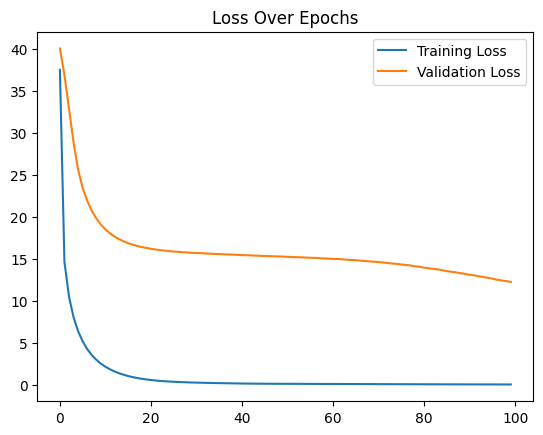

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold:  0.16420862
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
pred_aux: (array([False,  True]), array([  5, 333]))


In [6]:
#Boundary condition: primordial run

# The last element contains the labels
labels = anomaly_list
# The other data points are the data
data = X_analog

#new variables for the moving window problem
test_loss = []
preds_list = []
val_preds_list = []
threshold_list = []
k_list = []
beta_list = []
batch_limits = []

normal_train_data = np.empty((0, 16), dtype=np.float32)  # Empty array with correct shape
anomalous_train_data = np.empty((0, 16), dtype=np.float32)
normal_val_data = np.empty((0, 16), dtype=np.float32)
anomalous_val_data = np.empty((0, 16), dtype=np.float32)


test_cycle_normalized = np.empty((1, 16), dtype=np.float32)
test_cycle = np.empty((1, 16), dtype=np.float32)
good_cycles = np.empty((1,16), dtype=np.float32)


# Determine the split index (see image below: the train and validation sets will use only good data. Mixed data is desirable for testing)
index_mar = 1180+1 #March 1st index (+1 bc 1st cycle is problematic)
index_apr = 2954
index_mai = 4193 
index_jun = 5815
index_jul = 7611
time_delta = 7 # how many days at a time you want to test
last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=time_delta)) #Determine the last index of the test set
last_test_index_2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_apr]+pd.Timedelta(days=2*time_delta))

# Split the data and labels
train_data = data[index_mar:index_apr].astype(np.float32)
val_data = data[index_apr:index_mai]
test_data = data[index_mai:last_test_index].astype(np.float32) # Assuring we only test 1 week at a time
batch_limits.append([index_mai, last_test_index])


train_labels = labels[index_mar:index_apr]
train_len = len(train_labels)
val_labels = labels[index_apr:index_mai]
test_labels = labels[index_mai:last_test_index] # Assuring we only test 1 week at a time

#Pass to boolean
train_labels = train_labels.astype(bool)
val_labels = val_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Separate into normal and anomalous data
for i in range(len(train_labels)):
    if train_labels[i] == 0:
        normal_train_data = np.concatenate((normal_train_data, train_data[i:i+1, :]), axis=0)
    else:
        anomalous_train_data = np.concatenate((anomalous_train_data, train_data[i:i+1, :]), axis=0)

for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data = np.concatenate((normal_val_data, val_data[i:i+1, :]), axis=0)
    else:
        anomalous_val_data = np.concatenate((anomalous_val_data, val_data[i:i+1, :]), axis=0)


normal_train_data_normalized = np.zeros_like(normal_train_data)
test_data_normalized = np.zeros_like(test_data)
val_data_normalized = np.zeros_like(val_data)
normal_val_data_normalized = np.zeros_like(normal_val_data)
anomalous_val_data_normalized = np.zeros_like(anomalous_val_data)



scaler = MinMaxScaler()
normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,:7] = scaler.transform(val_data[:, :7].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 2 (columns 7-13)
normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,7:14] = scaler.transform(val_data[:, 7:14].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform Trun (column 14)
normal_train_data_normalized[:, 14] = scaler.fit_transform(normal_train_data[:, 14].reshape(-1, 1)).flatten()
test_data_normalized[:, 14] = scaler.transform(test_data[:, 14].reshape(-1, 1)).flatten()
val_data_normalized[:, 14] = scaler.transform(val_data[:, 14].reshape(-1, 1)).flatten()

# Fit and transform Tidle (column 15)
normal_train_data_normalized[:, 15] = scaler.fit_transform(normal_train_data[:, 15].reshape(-1, 1)).flatten()
test_data_normalized[:, 15] = scaler.transform(test_data[:, 15].reshape(-1, 1)).flatten()
val_data_normalized[:, 15] = scaler.transform(val_data[:, 15].reshape(-1, 1)).flatten()


#Separate into normal and anomalous data
for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data_normalized = np.concatenate((normal_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)
    else:
        anomalous_val_data_normalized = np.concatenate((anomalous_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)


# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data_normalized,  # Input and target are the same for autoencoders
    y=normal_train_data_normalized,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30,
    validation_data=(normal_val_data_normalized, normal_val_data_normalized),
    verbose=1
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_val = autoencoder.predict(val_data_normalized)
val_loss = tf.keras.losses.mae(reconstructions_val, val_data_normalized)

if 1 in val_labels:
    y_true = (np.array(val_labels) != 0).astype(int)
    scores = np.array(val_loss)

    # 1. Calculate precision, recall, and thresholds.
    precision, recall, thresholds = precision_recall_curve(y_true, scores)

    # Note: precision and recall arrays have one extra element compared to thresholds.
    # We'll compute F1 scores for the thresholds only.
    # F1 = 2 * (precision * recall) / (precision + recall)
    f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # added epsilon for safety
    # 2. Identify the best threshold (maximizing F1 score)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
##############################################################REPLACE TYKEY'S FENCES WITH 99-PERCENTILE
    # Compute quartiles and IQR
    Q1 = np.percentile(val_loss, 25)
    Q3 = np.percentile(val_loss, 75)
    IQR = Q3 - Q1
    # Compute k
    k = (best_threshold - Q3) / IQR
    #beta = best_threshold/np.percentile(val_loss, 99)
    
else:
    best_threshold = np.percentile(val_loss, 99) #REPLACE max(val_loss) by 99-percentile

    # Compute quartiles and IQR
    Q1 = np.percentile(val_loss, 25)
    Q3 = np.percentile(val_loss, 75)
    IQR = Q3 - Q1
    # Compute k
    k = (best_threshold - Q3) / IQR
    #beta = best_threshold/np.percentile(val_loss, 99)

threshold_list.append(best_threshold)
#beta_list.append(beta)
k_list.append(k)
print("Threshold: ", best_threshold)



# Calculate the reconstruction loss for the anomalous test data
reconstructions_test = autoencoder.predict(test_data_normalized)
val_pred = predict(autoencoder, val_data_normalized, best_threshold).numpy()
pred_aux = predict(autoencoder, test_data_normalized, best_threshold).numpy()
preds_list = np.concatenate((preds_list, pred_aux), axis=0)
'''pred_val_aux = val_labels #predict(autoencoder, normal_val_data_normalized, best_threshold)
val_preds_list = np.concatenate((val_preds_list, pred_val_aux), axis=0)'''
print("pred_aux:", np.unique(pred_aux, return_counts=True))

test_loss.extend(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())


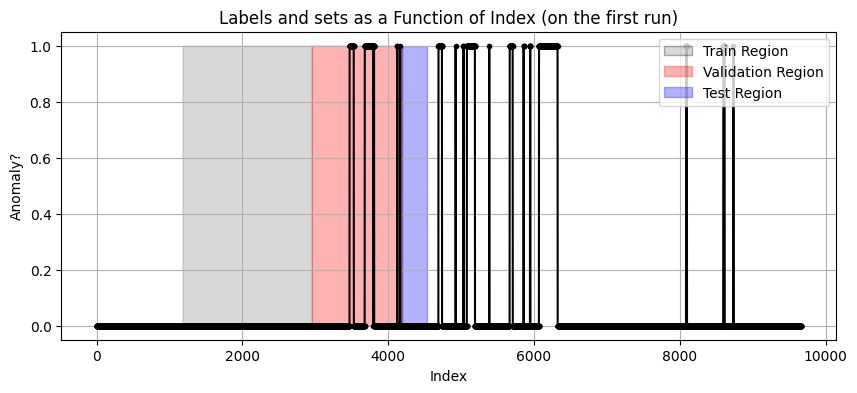

In [7]:
labels_int = [int(label) for label in labels]

# Plot the labels as a function of the index
plt.figure(figsize=(10, 4))
plt.plot(labels_int, '.-', color='black', label='Labels')
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= index_mar) & (np.arange(len(labels)) < index_apr), color='gray', alpha=0.3)
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= index_apr) & (np.arange(len(labels)) < index_mai), color='red', alpha=0.3)
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= index_mai)& (np.arange(len(labels)) < last_test_index), color='blue', alpha=0.3)
legend_elements = [Patch(facecolor='gray', edgecolor='black', alpha=0.3, label='Train Region'),
                   Patch(facecolor='red', edgecolor='r', alpha=0.3, label='Validation Region'),
                   Patch(facecolor='blue', edgecolor='b', alpha=0.3, label='Test Region')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Labels and sets as a Function of Index (on the first run)')
plt.grid(True)
plt.show()

#### Plotting the threshold with the test sets

In [8]:
normal_test_data_normalized = np.empty((0, 16), dtype=np.float32)  # Empty array with correct shape
anomalous_test_data_normalized = np.empty((0, 16), dtype=np.float32)
for i in range(len(test_labels)):
    if test_labels[i] == 0:
        normal_test_data_normalized = np.concatenate((normal_test_data_normalized, test_data_normalized[i:i+1, :]), axis=0)
    else:
        anomalous_test_data_normalized = np.concatenate((anomalous_test_data_normalized, test_data_normalized[i:i+1, :]), axis=0)
reconstructions_test_normal = autoencoder.predict(normal_test_data_normalized)
normal_test_loss = tf.keras.losses.mae(reconstructions_test_normal, normal_test_data_normalized)

try:
    reconstructions_test_anomalous = autoencoder.predict(anomalous_test_data_normalized)
    anomalous_test_loss = tf.keras.losses.mae(reconstructions_test_anomalous, anomalous_test_data_normalized)

    # Plot both losses on the same histogram
    plt.hist(normal_test_loss, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='blue', label='Normal')
    plt.hist(anomalous_test_loss, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='red', label='Anomalous')

    plt.xlabel("Reconstruction Loss")
    plt.ylabel("Number of Examples")
    plt.legend(loc='upper right')
    plt.title("Reconstruction Loss for Normal and Anomalous Data")
    plt.axvline(x=best_threshold, color='black', linestyle='--')
    #plt.ylim((0, 40))
    plt.show()
except:
    print("No anomalies in the test set")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
No anomalies in the test set


c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [9]:
anomalous_test_data_normalized

array([], shape=(0, 16), dtype=float32)

In [10]:
val_pred.shape

(1239,)

In [11]:
val_labels.shape

(1239,)

#### Moving window

Cycle: 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Point 2/16. k = 12.995376586914062


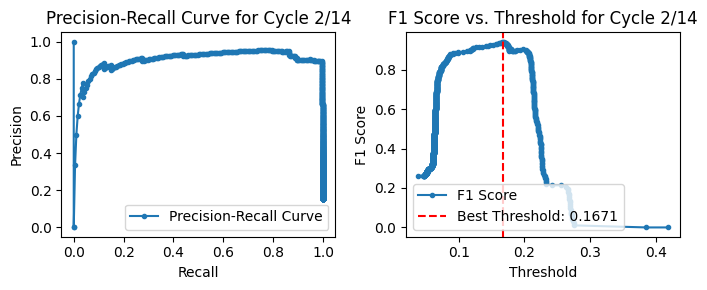

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([ 57, 227]))
Threshold:  0.16709751
Cycle: 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 3/16. k = 18.23626708984375


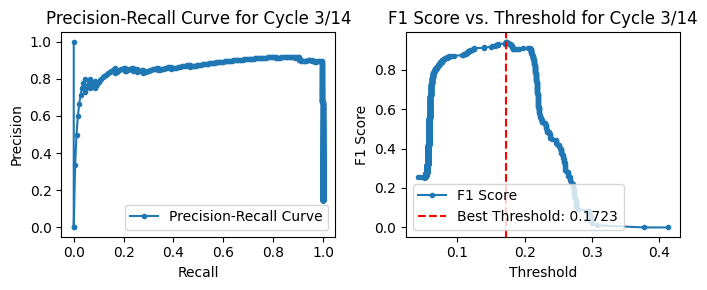

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([119, 416]))
Threshold:  0.17225417
Cycle: 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 4/16. k = 5.165608882904053


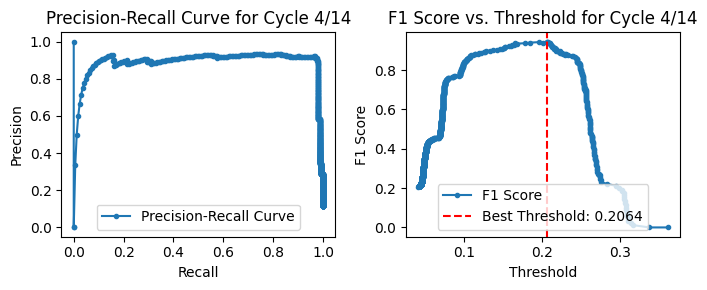

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  6, 305]))
Threshold:  0.20635086
Cycle: 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 5/16. k = 3.8361475467681885


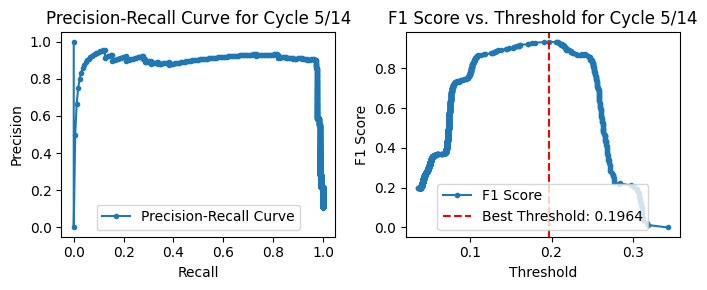

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([113, 356]))
Threshold:  0.1964356
Cycle: 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 6/16. k = 3.6680939197540283


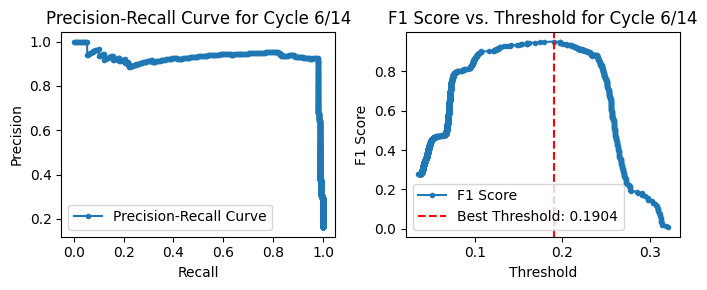

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([194, 255]))
Threshold:  0.19035381
Cycle: 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 7/16. k = -0.11505736410617828


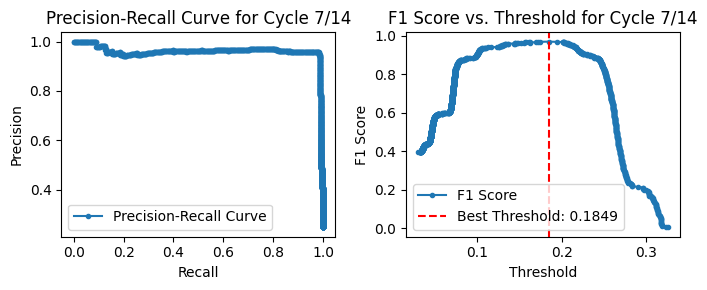

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
pred_aux: (array([False,  True]), array([  1, 538]))
Threshold:  0.1848926
Cycle: 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 8/16. k = 2.0721676349639893


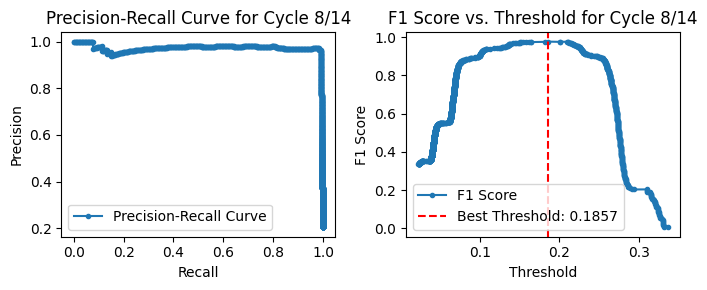

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  1, 315]))
Threshold:  0.18573181
Cycle: 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 9/16. k = 5.954685211181641


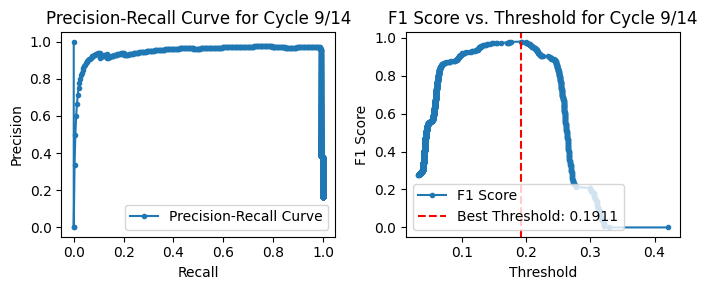

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
pred_aux: (array([False,  True]), array([  2, 388]))
Threshold:  0.19108254
Cycle: 9/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 10/16. k = 6.814484119415283


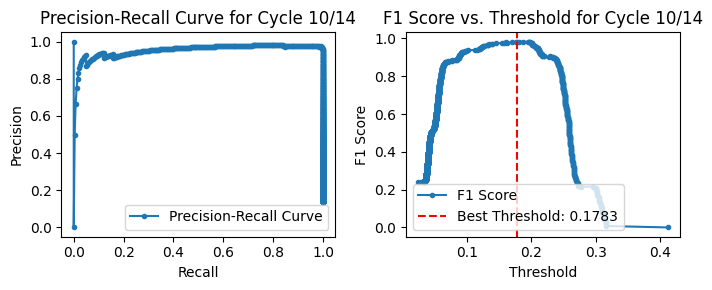

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([ 12, 438]))
Threshold:  0.17833987
Cycle: 10/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 11/16. k = 12.793251037597656


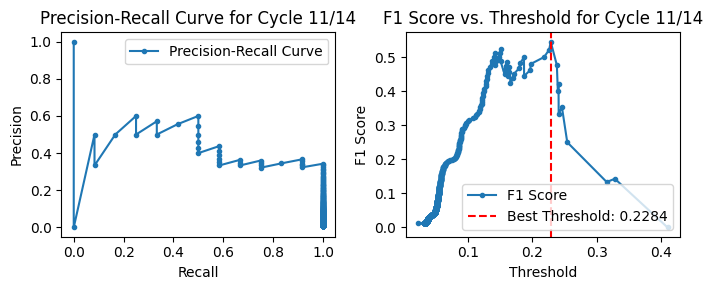

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([ 18, 502]))
Threshold:  0.22842829
Cycle: 11/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 12/16. k = 12.421603202819824


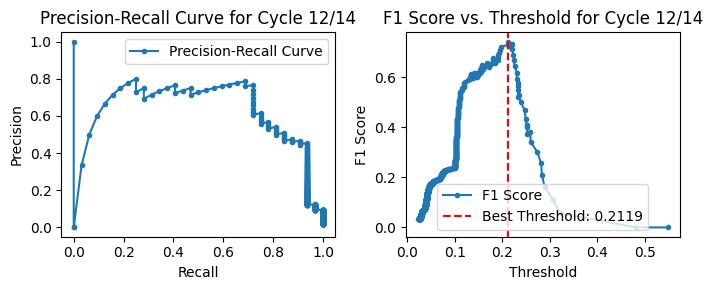

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
pred_aux: (array([False,  True]), array([  2, 448]))
Threshold:  0.21188311
Cycle: 12/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 13/16. k = 11.932123184204102


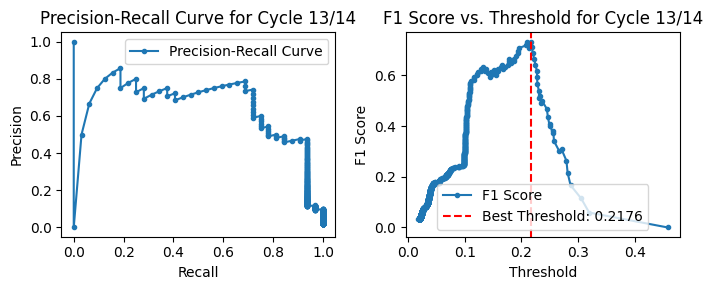

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
pred_aux: (array([False,  True]), array([  1, 415]))
Threshold:  0.21762745
Cycle: 13/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 14/16. k = 8.39393424987793


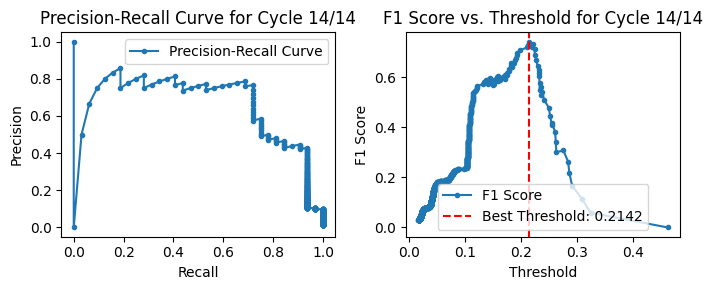

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
pred_aux: (array([ True]), array([5]))
Threshold:  0.21421778


In [12]:
n = 1
break_flag = False

#Computing number of cycles
for j in range(100):
    try:
        next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=j*time_delta))
        num_cycles = j+1
    except:
        break


while True:
    try:
        first_val_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_apr]+pd.Timedelta(days=n*time_delta))
        last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=n*time_delta))
        last_test_index_2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=(n+1)*time_delta))
        print(f"Cycle: {n}/{num_cycles+1}")
        test_data = data[last_test_index:last_test_index_2]
        batch_limits.append([last_test_index, last_test_index_2])


    except:
        first_val_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_apr]+pd.Timedelta(days=n*time_delta))
        last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=n*time_delta))
        print(f"Cycle: {n}/{num_cycles+1}")
        test_data = data[last_test_index:]
        batch_limits.append([last_test_index, len(labels)])

        break_flag = True


    val_data = data[first_val_index:last_test_index]
    val_labels = labels[first_val_index:last_test_index]

    if 1 in val_labels: #Update training set
        aux_train_indices = [i for i in range(first_val_index) if labels[i] == 0][-train_len:]  # Get the last train_len normal indices
        normal_train_data = data[aux_train_indices]

    normal_train_data_normalized = np.zeros_like(normal_train_data)
    test_data_normalized = np.zeros_like(test_data)
    val_data_normalized = np.zeros_like(val_data)
    normal_val_data_normalized = np.empty((0, 16), dtype=np.float32)
    anomalous_val_data_normalized = np.empty((0, 16), dtype=np.float32)


    scaler = MinMaxScaler()
    normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,:7] = scaler.transform(val_data[:, :7].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 2 (columns 7-13)
    normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,7:14] = scaler.transform(val_data[:, 7:14].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform Trun (column 14)
    normal_train_data_normalized[:, 14] = scaler.fit_transform(normal_train_data[:, 14].reshape(-1, 1)).flatten()
    test_data_normalized[:, 14] = scaler.transform(test_data[:, 14].reshape(-1, 1)).flatten()
    val_data_normalized[:, 14] = scaler.transform(val_data[:, 14].reshape(-1, 1)).flatten()

    # Fit and transform Tidle (column 15)
    normal_train_data_normalized[:, 15] = scaler.fit_transform(normal_train_data[:, 15].reshape(-1, 1)).flatten()
    test_data_normalized[:, 15] = scaler.transform(test_data[:, 15].reshape(-1, 1)).flatten()
    val_data_normalized[:, 15] = scaler.transform(val_data[:, 15].reshape(-1, 1)).flatten()


    #Separate into normal and anomalous data
    for i in range(len(val_labels)):
        if val_labels[i] == True:
            normal_val_data_normalized = np.concatenate((normal_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)
        else:
            anomalous_val_data_normalized = np.concatenate((anomalous_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)

    if 1 in val_labels:
        # Compile the model with the custom loss
        autoencoder.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
        )

        # Train the model
        history = autoencoder.fit(
            x=normal_train_data_normalized,  # Input and target are the same for autoencoders
            y=normal_train_data_normalized,  # Input and target are the same for autoencoders
            epochs=100,
            batch_size=30,
            validation_data=(normal_val_data_normalized, normal_val_data_normalized),
            verbose=0
        )

    ## Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
    reconstructions_val = autoencoder.predict(val_data_normalized)
    val_loss = tf.keras.losses.mae(reconstructions_val, val_data_normalized)

    if 1 in val_labels:
        y_true = (np.array(val_labels) != 0).astype(int)
        scores = np.array(val_loss)

        # 1. Calculate precision, recall, and thresholds.
        precision, recall, thresholds = precision_recall_curve(y_true, scores)

        # Note: precision and recall arrays have one extra element compared to thresholds.
        # We'll compute F1 scores for the thresholds only.
        # F1 = 2 * (precision * recall) / (precision + recall)
        f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # added epsilon for safety
        # 2. Identify the best threshold (maximizing F1 score)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]

        # Compute quartiles and IQR
        Q1 = np.percentile(val_loss, 25)
        Q3 = np.percentile(val_loss, 75)
        IQR = Q3 - Q1
        # Compute k
        k = (best_threshold - Q3) / IQR
        print(f"Point {n+1}/16. k = {k}")
        #beta = best_threshold/np.percentile(val_loss, 99)
        


        ######################################
        plt.figure(figsize=(7, 3))

        plt.subplot(1, 2, 1)
        plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve for Cycle {n+1}/{num_cycles}")
        plt.legend()

        # Plot F1 Score vs. Threshold
        plt.subplot(1, 2, 2)
        plt.plot(thresholds, f1_scores, marker='.', label="F1 Score")
        plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Best Threshold: {best_threshold:.4f}")
        plt.xlabel("Threshold")
        plt.ylabel("F1 Score")
        plt.title(f"F1 Score vs. Threshold for Cycle {n+1}/{num_cycles}")
        plt.legend()

        plt.tight_layout()
        plt.show()
        ######################################
    #Comment out the 'else' if what you want to keep constant is the THRESHOLD and NOT the value of k
    else:
        # Compute quartiles and IQR
        Q1 = np.percentile(val_loss, 25)
        Q3 = np.percentile(val_loss, 75)
        IQR = Q3 - Q1
        best_threshold = Q3 + k * IQR
        #best_threshold = beta*np.percentile(val_loss, 99)
    
    k_list.append(k)
    #beta_list.append(beta)
    threshold_list.append(best_threshold)
    
    
    # Calculate the reconstruction loss for the anomalous test data
    pred_val_aux = pred_aux #former test set is now validation set. Use former cycle's test labels as validation labels in this cycle
    reconstructions_test = autoencoder.predict(test_data_normalized)
    pred_aux = []
    pred_aux = predict(autoencoder, test_data_normalized, best_threshold).numpy().astype(bool)
    preds_list = np.concatenate((preds_list, pred_aux), axis=0)
    print("pred_aux:", np.unique(pred_aux, return_counts=True))
    print("Threshold: ", best_threshold)

    test_loss.extend(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())
    if break_flag==True:
        break
    n += 1

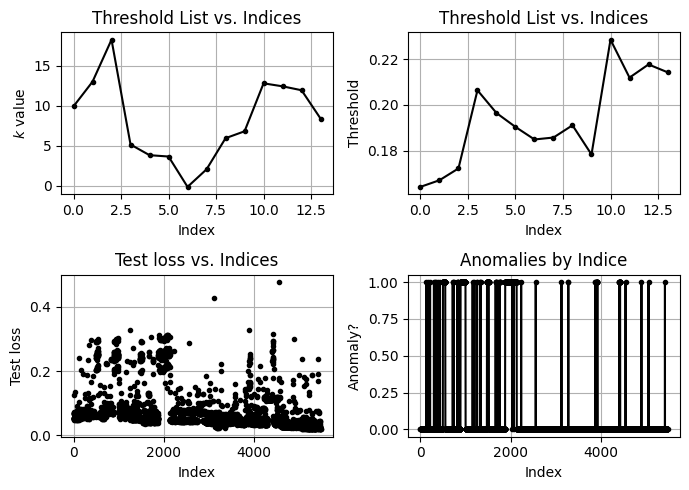

In [20]:
plt.figure(figsize=(7, 5))

# Plot k_list against the respective indices
plt.subplot(2, 2, 1)
plt.plot(k_list[:], marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('$k$ value')
plt.title('Threshold List vs. Indices')
plt.grid(True)

# Plot threshold_list against the respective indices
plt.subplot(2, 2, 2)
plt.plot(threshold_list[:], marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Threshold')
plt.title('Threshold List vs. Indices')
plt.grid(True)

# Plot test_loss against the respective indices
plt.subplot(2, 2, 3)
plt.plot(test_loss, marker='.', linestyle=' ', color='black')
plt.xlabel('Index')
plt.ylabel('Test loss')
plt.title('Test loss vs. Indices')
plt.grid(True)

# Convert boolean values: True -> 0, False -> 1
plot_preds_list = [0 if pred else 1 for pred in preds_list]

# Plot the converted preds_list
plt.subplot(2, 2, 4)
plt.plot(plot_preds_list, marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Anomalies by Indice')
plt.grid(True)

plt.tight_layout()
plt.show()

## Metrics and Confusion Matrix

In [14]:
len(data[next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=time_delta)):])


5134

Segment 0: start=0, end=338, threshold=0.16420862078666687
Segment 1: start=338, end=622, threshold=0.16709750890731812
Segment 2: start=622, end=1157, threshold=0.17225417494773865
Segment 3: start=1157, end=1468, threshold=0.20635086297988892
Segment 4: start=1468, end=1937, threshold=0.1964356005191803
Segment 5: start=1937, end=2386, threshold=0.19035381078720093
Segment 6: start=2386, end=2925, threshold=0.18489259481430054
Segment 7: start=2925, end=3241, threshold=0.18573181331157684
Segment 8: start=3241, end=3631, threshold=0.19108253717422485
Segment 9: start=3631, end=4081, threshold=0.1783398687839508
Segment 10: start=4081, end=4601, threshold=0.22842828929424286
Segment 11: start=4601, end=5051, threshold=0.21188311278820038
Segment 12: start=5051, end=5467, threshold=0.21762745082378387
Segment 13: start=5467, end=5472, threshold=0.21421778202056885


c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


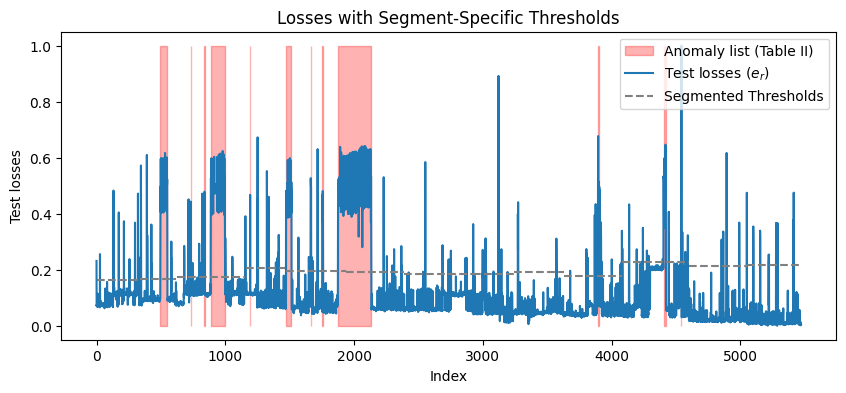

In [15]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
conf_matrix_list = []

# Reshape test_loss to a 2D array and fit and transform it
test_loss_normalized = scaler.fit_transform(np.array(test_loss).reshape(-1, 1)).flatten()
aux_index = index_mai
anomaly_list_binary = np.array(anomaly_list[aux_index:], dtype=int)

def compute_f1_for_threshold(anomaly_list_binary, test_loss_normalized, threshold):
    predicted_anomalies = (tf.convert_to_tensor(test_loss_normalized) >= threshold).numpy().astype(int)
    return f1_score(anomaly_list_binary, predicted_anomalies), predicted_anomalies

for i in range(len(threshold_list)):
    start_idx = batch_limits[i][0] - batch_limits[0][0]  # Start index of the segment
    end_idx = batch_limits[i][1] - batch_limits[0][0]  # End index
    # Function to compute F1-score for a given threshold
    # Search for the best threshold
    thresholds = np.linspace(0, 1, 10000)
    best_threshold = threshold_list[i]
    best_f1, best_predictions = compute_f1_for_threshold(anomaly_list_binary[start_idx:end_idx], test_loss_normalized[start_idx:end_idx], best_threshold)
    # Compute confusion matrix
    conf_matrix_list.append(confusion_matrix(anomaly_list_binary[start_idx:end_idx], best_predictions, labels=[0, 1]))


# Plot test losses
aux_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai])
plt.figure(figsize=(10, 4))
plt.fill_between(range(len(anomaly_list[aux_index:])), 0, 1, where=np.array(anomaly_list[aux_index:]) == 1, 
                 color='red', alpha=0.3, label='Anomaly list (Table II)')
plt.plot(test_loss_normalized, label="Test losses ($e_r$)", linestyle='-')

# Plot segmented threshold lines
for i in range(len(threshold_list)):
    start_idx = batch_limits[i][0] - batch_limits[0][0]  # Start index of the segment
    end_idx = batch_limits[i][1] - batch_limits[0][0]  # End index

    print(f"Segment {i}: start={start_idx}, end={end_idx}, threshold={threshold_list[i]}")
    
    # Ensure non-overlapping segments
    if start_idx < end_idx:
        plt.plot(range(start_idx, end_idx), 
                 threshold_list[i]*np.ones(end_idx - start_idx), 
                 linestyle='--', color='gray')

# Add legend for threshold
custom_legend = [Line2D([0], [0], color='gray', linestyle='--', label="Segmented Thresholds")]
plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_legend, loc='upper right')

# Formatting
plt.title('Losses with Segment-Specific Thresholds')
plt.xlabel('Index')
plt.ylabel('Test losses')
plt.show()

Confusion Matrix = 
| True Negatives |     False Positives |
| -------------  |  --------------- |
| **False Negatives**   |  **True Positives** |

In [19]:
cm = np.sum(conf_matrix_list, axis=0)
TN, FP, FN, TP = cm.ravel()

# Computing metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = (TP / (TP + FP)) if (TP + FP) > 0 else 0
recall = (TP / (TP + FN)) if (TP + FN) > 0 else 0
f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

# Display results
print("Confusion Matrix with custom thresholds:")
print(f"{cm}\n")

print(f"Accuracy = {100*accuracy:.2f}%")
print(f"Precision = {100*precision:.2f}%")
print(f"Recall = {100*recall:.2f}%")
print(f"F1 Score = {100*f1_score:.2f}%")

Confusion Matrix with custom thresholds:
[[4799  168]
 [   7  498]]

Accuracy = 96.80%
Precision = 74.77%
Recall = 98.61%
F1 Score = 85.06%
